In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, BatchSampler, RandomSampler
from torchvision import datasets
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR

In [28]:
# set random seed
torch.manual_seed(198964)
torch.cuda.manual_seed(198964)

# arguments
batch_size = 64
test_batch_size = 1000
epochs = 14
device = 'cuda'

# model class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 0)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.BN16 = nn.BatchNorm2d(16)
        self.BN32 = nn.BatchNorm2d(32)
        self.BN64 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*3*3, 32)
        self.fc2 = nn.Linear(32, 10)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.BN16(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.BN32(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.BN64(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        output = self.softmax(x)
        return output


# train function
def train(data_loader, model, optimizer, loss_history, acc_history):
    model.train()
    total_batchs = len(data_loader)
    data_size = len(data_loader.dataset)
    train_loss, correct = 0, 0
    equal = '='
    arrow = '>'
    hyphen = '-'
    for batch, (data, label) in enumerate(data_loader):
        data, label = data.to(device), label.to(device)
        pred = model(data)
        loss = F.cross_entropy(pred, label)
        train_loss += loss.item()
        correct += (pred.argmax(dim=1) == label).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        bar_num = int(20 * ((batch+1) / total_batchs))
        avg_loss = train_loss / (batch+1)
        acc = 100. * correct / data_size
        print(f'[{bar_num*equal + arrow + (20-bar_num)*hyphen}]\tTraining Loss: {avg_loss:.4f}\tTraining Accuracy: {acc:.1f}%', end='\r')
    loss_history.append(avg_loss)
    acc_history.append(acc)
    print()
        
# eval function
def evaluate(data_loader, model, loss_history, acc_history):
    model.eval()
    total_batchs = len(data_loader)
    data_size = len(data_loader.dataset)
    eval_loss, correct = 0, 0
    with torch.no_grad():
        for data, label in data_loader:
            data, label = data.to(device), label.to(device)
            pred = model(data)
            eval_loss += F.cross_entropy(pred, label, reduction = 'sum').item()
            correct += (pred.argmax(dim=1) == label).type(torch.float).sum().item()
    eval_loss /= data_size
    correct /= data_size
    loss_history.append(eval_loss)
    acc_history.append(100. * correct)
    print(f'\t\t\tValidation Loss: {eval_loss:.4f}\tValidation Accuracy: {100*correct:.1f}%')

        

# test function
def test(data_loader, model):
    model.eval()
    total_batchs = len(data_loader)
    data_size = len(data_loader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data, label in data_loader:
            data, label = data.to(device), label.to(device)
            pred = model(data)
            test_loss += F.cross_entropy(pred, label, reduction = 'sum').item()
            correct += (pred.argmax(dim=1) == label).type(torch.float).sum().item()
    test_loss /= data_size
    correct /= data_size
    print(f'\nTest Loss: {test_loss:.4f}\tTest Accuracy: {100*correct:.1f}%\n')



# transform
train_tr = T.Compose([
    T.ToTensor()
])
eval_tr = T.Compose([
    T.ToTensor()
])

# load data
train_data = datasets.FashionMNIST(
    root='../data',
    train=True,
    download=True,
    transform=train_tr
)
test_data = datasets.FashionMNIST(
    root='../data',
    train=False,
    download=True,
    transform=eval_tr
)

(val_data, test_data) = random_split(test_data, [5000, 5000], generator=torch.Generator().manual_seed(198964))

# data loader
train_loader = DataLoader(train_data, batch_sampler=BatchSampler(RandomSampler(train_data, generator=torch.Generator().manual_seed(198964)), batch_size=batch_size, drop_last=False))
val_loader = DataLoader(val_data, batch_sampler=BatchSampler(RandomSampler(val_data, generator=torch.Generator().manual_seed(198964)), batch_size=test_batch_size, drop_last=False))
test_loader = DataLoader(test_data, batch_sampler=BatchSampler(RandomSampler(test_data, generator=torch.Generator().manual_seed(198964)), batch_size=test_batch_size, drop_last=False))

In [ ]:
# build model
model = Net().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, verbose=True)
train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in range(epochs):
    print(f'Epoch {epoch+1}:')
    train(train_loader, model, optimizer, train_loss, train_acc)
    evaluate(val_loader, model, val_loss, val_acc)
    scheduler.step()
    
test(test_loader, model)

# save model
from torch.jit import save, load, script

m = script(Net())
save(m, 'fmnist_module.pt')
torch.save(model.state_dict(), 'fmnist_state_dict.pt')

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1:
[====================>]	Training Loss: 0.4388	Training Accuracy: 84.0%
			Validation Loss: 0.3247	Validation Accuracy: 88.2%
Adjusting learning rate of group 0 to 9.8746e-03.
Epoch 2:
[====================>]	Training Loss: 0.2902	Training Accuracy: 89.5%
			Validation Loss: 0.2886	Validation Accuracy: 89.8%
Adjusting learning rate of group 0 to 9.5048e-03.
Epoch 3:
[====================>]	Training Loss: 0.2578	Training Accuracy: 90.7%
			Validation Loss: 0.2807	Validation Accuracy: 89.9%
Adjusting learning rate of group 0 to 8.9092e-03.
Epoch 4:
[====================>]	Training Loss: 0.2349	Training Accuracy: 91.3%
			Validation Loss: 0.3604	Validation Accuracy: 87.2%
Adjusting learning rate of group 0 to 8.1174e-03.
Epoch 5:
[====================>]	Training Loss: 0.2137	Training Accuracy: 92.2%
			Validation Loss: 0.2636	Validation Accuracy: 90.7%
Adjusting learning rate of group 0 to 7.1694e-03.
Epoch 6:
[====================

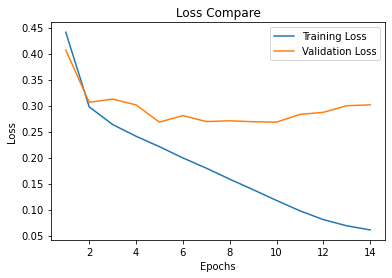

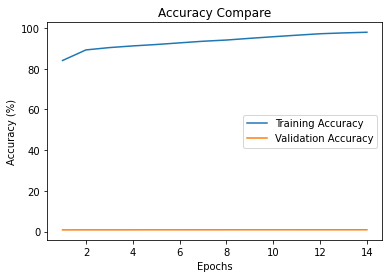

In [27]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(1, epochs+1)
loss_graph = plt.subplot(title='Loss Compare', xlabel='Epochs', ylabel='Loss')
loss_graph = plt.plot(x, train_loss, label='Training Loss')
loss_graph =  plt.plot(x, val_loss, label='Validation Loss')
plt.legend()
plt.show()
acc_graph = plt.subplot(title='Accuracy Compare', xlabel='Epochs', ylabel=r'Accuracy (%)')
acc_graph = plt.plot(x, train_acc, label='Training Accuracy')
acc_graph = plt.plot(x, val_acc, label='Validation Accuracy')
plt.legend()
plt.show()